# Projeto — Perfumes & Psicofisiologia

**Objetivo:** O presente relatório tem como objetivo apresentar uma análise completa do dataset Perfume & Psychology, que reúne informações extraídas de literatura científica sobre materiais odorantes, seus componentes químicos, alterações psicofisiológicas descritas em textos e funções cerebrais ativadas. O estudo foi conduzido com o intuito de aplicar técnicas avançadas de ciência de dados, envolvendo limpeza, integração, análise exploratória, testes estatísticos, modelagem preditiva e otimização.
A investigação se fundamenta na hipótese principal de que perfumes que ativam mais funções cerebrais demandariam descrições psicofisiológicas mais longas, sugerindo maior complexidade neuropsicológica. Com base nisso, métodos de correlação e análise de variância foram empregados para verificar tal relação, além da implementação de modelos de regressão e classificação para previsão de efeitos psicofisiológicos e alterações em EEG.

**Dataset:** Perfume & Psychology (conjunto composto por `perfume_Brainfunc.csv`, `perfume_compound.csv`, `perfume_Psycho.csv`).

**Hipótese 1 (H4):** Perfumes com maior número de funções cerebrais ativadas possuem textos psicofisiológicos mais longos.

**Hipótese 2 (H1):**  Perfumes com efeitos psicofisiológicos calmantes reduzem a atividade EEG.

**Hipótese 3 (H1):**  Perfumes com mais componentes químicos produzem mudanças EEG mais intensas.

**Variáveis-alvo:**
- Regressão primária: `eeg_change_num` (−1: decrease, 0: no change, 1: increase).
- Classificação: `psych_label` (4 classes).
**Ambiente:** Python (pandas, seaborn, statsmodels, scikit-learn, pycaret opcional).

Seed usada em todo projeto: `42`.


# Setup + Carregamento dos Dados

Este trecho do código inicia o ambiente do projeto configurando bibliotecas, estilo visual, reprodutibilidade e a estrutura de diretórios necessários para armazenar dados, artefatos e figuras. No começo, são importadas bibliotecas essenciais: pandas e numpy para manipulação de dados, matplotlib e seaborn para gráficos, pathlib para gerenciar caminhos, joblib para salvar objetos e random para operações aleatórias. Os warnings são desativados para deixar as saídas mais limpas. Em seguida, seeds globais são definidos para garantir que qualquer operação aleatória produza sempre o mesmo resultado, deixando o projeto reprodutível. Diretórios importantes são configurados: data/Perfume&Psychology como fonte dos datasets, artifacts/ para salvar arquivos gerados durante o processo, e figures/ para armazenar gráficos; esses diretórios são criados automaticamente se ainda não existirem.

Logo após o setup, é definida uma função auxiliar simples chamada load_csv, responsável por localizar e carregar arquivos CSV dentro da pasta de dados do projeto. Ela imprime o nome do arquivo e seu tamanho (linhas × colunas), facilitando o acompanhamento do carregamento. Em seguida, três datasets principais do projeto são carregados: perfume_Brainfunc.csv, contendo medidas de atividade cerebral; perfume_compound.csv, com informações químicas dos perfumes; e perfume_Psycho.csv, com respostas psicológicas dos participantes. Para uma inspeção inicial, são exibidas as primeiras linhas de cada tabela com display(), permitindo verificar rapidamente a estrutura, colunas e possíveis inconsistências antes de seguir com etapas posteriores da análise


In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
import joblib
import random

random.seed(42)
np.random.seed(42)

ROOT = Path('.').resolve()
DATA_DIR = ROOT / "data" / "Perfume&Psychology"
ART = ROOT / "artifacts"
FIG = ROOT / "figures"
ART.mkdir(exist_ok=True)
FIG.mkdir(exist_ok=True)


def load_csv(name):
    p = DATA_DIR / name
    df = pd.read_csv(p)
    print(f"Loaded {name} -> shape {df.shape}")
    return df


brain = load_csv("perfume_Brainfunc.csv")
comp = load_csv("perfume_compound.csv")
psy = load_csv("perfume_Psycho.csv")

# show heads
display(brain.head())
display(comp.head())
display(psy.head())


Loaded perfume_Brainfunc.csv -> shape (42, 5)
Loaded perfume_compound.csv -> shape (23, 3)
Loaded perfume_Psycho.csv -> shape (38, 4)


,S. No.,Odorant Materials,EEG Wave Changes,Brain Functions,Reference
0,1.0,Galaxolide,Alpha decreased.,Odors produce divided attention even when unde...,[74]
1,2.0,m-Xylene,Alpha increased.,Stimulating and excitatory effects.,[75]
2,3.0,"Birch tar, galbanum, heliotropine, jasmine, la...","Increased theta for birch tar, jasmine, lavend...",Subjects differed in their subjective response...,[80]
3,4.0,"5-α-Androstan-3-one, bangalol, white sapphire,...",Alpha increased.,From more anterior electrodes—related to psych...,[70]
4,5.0,Phenylethyl alcohol and valeric acid,Valeric acid—alpha 2 increased.,Unpleasant odor leads to a cortical deactivation.,[76]


,Plants Name,Botanical Name,Major Components
0,Bergamot,Citrus bergamia,"limonene, linalool, linalyl acetate"
1,Caraway,Carum carvi,"carvone, limonene"
2,Chamomile,Matricaria chamomilla,"α-bisabolol, bisabolol oxide B, (E)-β-farnesen..."
3,Cinnamon,Cinnamomum zeylanicum,"cinnamaldehyde, cinnamyl acetate"
4,Cornmint,Mentha arvensis,"menthol, menthone, isomenthone, menthyl acetate"


,S. No.,Odorant Materials,Psychophysiological Changes,Reference
0,1.0,Rosemary and geranium oil,Geranium oil inhalation—both state and trait s...,[113]
1,2.0,"Ylang-ylang, orange, geranium, cypress, bergam...",Cypress produced favorable impression after ph...,[114]
2,3.0,Orange,"Relaxant effect—lower level of state anxiety, ...",[115]
3,4.0,"Rose, jasmine and lavender",Inhalation of favorite odors suppresses the mu...,[116]
4,5.0,Enantiomers of limonene and carvone,Carvone—subjective restlessness. Prolonged inh...,[120]


# Normalização, Padronização e Identificação da Chave de Junção

Nesta parte do código, é feita a preparação das três bases de dados para garantir consistência e permitir que sejam integradas corretamente. Primeiro, são definidas funções auxiliares: norm_cols, que remove espaços indesejados nos nomes das colunas, e clean_text, que padroniza strings removendo excesso de espaços e garantindo um formato limpo. Essas funções são aplicadas aos dataframes brain, comp e psy para padronizar suas colunas e garantir que operações posteriores não falhem por inconsistências simples de formatação.

Em seguida, o código tenta identificar automaticamente qual coluna de cada dataset representa o nome do odor — a variável que será usada como chave para conectar as três tabelas. A busca é feita examinando todas as colunas e procurando palavras como “odor”, “material”, “plant” ou “name”. Se uma coluna correspondente for encontrada, ela é renomeada para odorant, criando uma padronização comum. Caso contrário, uma coluna vazia odorant é criada para evitar erros futuros.

Após unificar o nome da coluna-chave, o código realiza uma limpeza textual nessa coluna em cada dataset, removendo espaços extras e normalizando as entradas. Isso garante que valores iguais não sejam tratados como diferentes devido a formatação irregular. Por fim, é exibido o número de valores únicos de odorant em cada tabela e também são mostrados os nomes finais das colunas de brain, comp e psy, permitindo verificar se tudo foi padronizado corretamente antes de prosseguir com análises e junções entre as bases.

In [2]:
def norm_cols(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    return df


def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s


brain = norm_cols(brain)
comp = norm_cols(comp)
psy = norm_cols(psy)

# inferir colunas-chave
brain_key = next((c for c in brain.columns if "odor" in c.lower() or "material" in c.lower()), None)
comp_key = next((c for c in comp.columns if "plant" in c.lower() or "name" in c.lower()), None)
psy_key = next((c for c in psy.columns if "odor" in c.lower() or "material" in c.lower()), None)

# renomear para odorant
if brain_key:
    brain = brain.rename(columns={brain_key: 'odorant'})
else:
    brain['odorant'] = ''
if comp_key:
    comp = comp.rename(columns={comp_key: 'odorant'})
else:
    comp['odorant'] = ''
if psy_key:
    psy = psy.rename(columns={psy_key: 'odorant'})
else:
    psy['odorant'] = ''

# limpar strings
brain['odorant'] = brain['odorant'].apply(clean_text)
comp['odorant'] = comp['odorant'].apply(clean_text)
psy['odorant'] = psy['odorant'].apply(clean_text)

print("Unique counts:", len(brain['odorant'].unique()), len(comp['odorant'].unique()), len(psy['odorant'].unique()))
display(brain.columns)
display(comp.columns)
display(psy.columns)


Unique counts: 41 23 32


Index(['S. No.', 'odorant', 'EEG Wave Changes', 'Brain Functions',
       'Reference'],
      dtype='object')

Index(['odorant', 'Botanical Name', 'Major Components'], dtype='object')

Index(['S. No.', 'odorant', 'Psychophysiological Changes', 'Reference'], dtype='object')

# Junção das Bases e Construção do Dataset

Nesta etapa, as três bases previamente padronizadas são finalmente integradas em um único dataset consolidado. A junção é realizada utilizando a coluna odorant, que foi identificada e normalizada anteriormente. O processo começa combinando a base brain com a base psy, utilizando um merge do tipo left, garantindo que todas as observações de atividade cerebral sejam preservadas mesmo que algumas não tenham correspondência psicológica. Em seguida, o resultado dessa junção é novamente combinado com a base comp, também como left merge, incorporando informações químicas sempre que disponíveis.

Esse encadeamento de merges cria um dataframe completo contendo, para cada odor estudado, suas medidas cerebrais, psicológicas e químicas. Após a junção, o código imprime o tamanho final do dataset integrado, permitindo verificar quantas linhas e colunas foram geradas, e exibe as primeiras observações para inspeção visual. Por fim, o dataframe consolidado é salvo em artifacts/df_merged.csv, criando uma versão persistente do dataset unificado para uso posterior em análises, modelagem ou visualizações.Feature engineering robusto (cria eeg_change_num, psych_label, counts)

In [3]:
# Merge brain <- psy <- comp on 'odorant' (left fallback)
df = brain.merge(psy, on='odorant', how='left', suffixes=('_brain', '_psy'))
df = df.merge(comp, on='odorant', how='left')
print("Merged df shape:", df.shape)
display(df.head(8))
df.to_csv(ART / 'df_merged.csv', index=False)


Merged df shape: (44, 10)


,S. No._brain,odorant,EEG Wave Changes,Brain Functions,Reference_brain,S. No._psy,Psychophysiological Changes,Reference_psy,Botanical Name,Major Components
0,1.0,Galaxolide,Alpha decreased.,Odors produce divided attention even when unde...,[74],NaN,NaN,NaN,NaN,NaN
1,2.0,m-Xylene,Alpha increased.,Stimulating and excitatory effects.,[75],NaN,NaN,NaN,NaN,NaN
2,3.0,"Birch tar, galbanum, heliotropine, jasmine, la...","Increased theta for birch tar, jasmine, lavend...",Subjects differed in their subjective response...,[80],NaN,NaN,NaN,NaN,NaN
3,4.0,"5-α-Androstan-3-one, bangalol, white sapphire,...",Alpha increased.,From more anterior electrodes—related to psych...,[70],NaN,NaN,NaN,NaN,NaN
4,5.0,Phenylethyl alcohol and valeric acid,Valeric acid—alpha 2 increased.,Unpleasant odor leads to a cortical deactivation.,[76],NaN,NaN,NaN,NaN,NaN
5,6.0,Lavender and rosemary,Lavender—beta increased. Rosemary—frontal alph...,Lavender—increased drowsiness. Rosemary—increa...,[9],NaN,NaN,NaN,NaN,NaN
6,7.0,"Synthetic odors—almond, chocolate, spearmint, ...",Chocolate odor—less theta activity.,Reduced level of attention.,[59],NaN,NaN,NaN,NaN,NaN
7,8.0,Chewing of marketed gum,Alpha power increased.,Arousal psychosomatic responses.,[77],NaN,NaN,NaN,NaN,NaN


# Engenharia de Atributos para EEG, Psicologia e Composição

Nesta fase, o dataset unificado é recarregado e passa por um conjunto de transformações destinadas a extrair informações numéricas e textuais importantes para análises posteriores. Primeiro, é criada uma função map_eeg que converte descrições qualitativas de mudanças em ondas cerebrais (como “increase”, “reduced”, “no change”) em valores numéricos padronizados: 1 para aumento, -1 para diminuição e 0 para ausência de mudança ou casos não identificados. A coluna original EEG Wave Changes é limpa e transformada usando essa função, gerando a nova variável eeg_change_num. Em paralelo, o texto bruto das mudanças psicofisiológicas é normalizado em uma versão reduzida (psych_label), com letras minúsculas, remoção de caracteres especiais e substituição de valores ausentes por “unknown”. Para enriquecer a análise textual, são criadas métricas simples como psych_text_len (tamanho do texto) e psych_word_count (número de palavras). A composição química e as funções cerebrais também passam por parsing estruturado: tanto Major Components quanto Brain Functions têm seus itens separados por delimitadores comuns (;, ,, /, |), resultando nos contadores compound_count e brainfunc_count, que indicam quantos elementos distintos cada registro possui. Por fim, o dataset enriquecido é salvo como df_features.csv e uma amostra das principais novas variáveis é exibida para conferência.

In [4]:
df = pd.read_csv(ART / 'df_merged.csv')


# robust mapping EEG -> numeric
def map_eeg(s):
    s = str(s).lower()
    inc = ['increase', 'increased', 'enhance', 'enhanced', 'rise', 'up', 'higher', 'augment']
    dec = ['decrease', 'decreased', 'reduce', 'reduced', 'down', 'lower', 'diminish', 'suppressed']
    for t in inc:
        if t in s: return 1
    for t in dec:
        if t in s: return -1
    # check 'no change' patterns
    if 'no change' in s or 'no significant' in s or 'no effect' in s or 'unchanged' in s:
        return 0
    return 0


df['EEG Wave Changes'] = df.get('EEG Wave Changes', '').fillna('').astype(str)
df['eeg_change_num'] = df['EEG Wave Changes'].apply(map_eeg)

# clean psych label
df['Psychophysiological Changes'] = df.get('Psychophysiological Changes', '').fillna('').astype(str)
df['psych_label'] = df['Psychophysiological Changes'].str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True).str.strip()
df['psych_label'] = df['psych_label'].replace({'nan': 'unknown', '': 'unknown', 'none': 'unknown'})

# counts and text features
df['psych_text_len'] = df['Psychophysiological Changes'].astype(str).apply(lambda s: len(s))
df['psych_word_count'] = df['Psychophysiological Changes'].astype(str).apply(lambda s: len(s.split()))
df['Major Components'] = df.get('Major Components', '').fillna('').astype(str)
df['compound_count'] = df['Major Components'].apply(
    lambda s: 0 if s.strip() == '' else len([p for p in re.split(r'[;,/|]+', s) if p.strip()]))
df['Brain Functions'] = df.get('Brain Functions', '').fillna('').astype(str)
df['brainfunc_count'] = df['Brain Functions'].apply(
    lambda s: 0 if s.strip() == '' else len([p for p in re.split(r'[;,/|]+', s) if p.strip()]))

# save
df.to_csv(ART / 'df_features.csv', index=False)
print("Features saved, shape:", df.shape)
display(df[['odorant', 'psych_label', 'eeg_change_num', 'psych_text_len', 'psych_word_count', 'compound_count',
            'brainfunc_count']].head(10))


Features saved, shape: (44, 16)


,odorant,psych_label,eeg_change_num,psych_text_len,psych_word_count,compound_count,brainfunc_count
0,Galaxolide,unknown,-1,0,0,0,1
1,m-Xylene,unknown,1,0,0,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",unknown,1,0,0,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",unknown,1,0,0,0,1
4,Phenylethyl alcohol and valeric acid,unknown,1,0,0,0,1
5,Lavender and rosemary,unknown,1,0,0,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",unknown,0,0,0,0,1
7,Chewing of marketed gum,unknown,1,0,0,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",unknown,1,0,0,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",unknown,-1,0,0,0,1


# Análises Estatísticas, Visualizações e Testes de Hipóteses

Nesta etapa, o dataset enriquecido é recarregado e submetido a um conjunto de análises estatísticas para investigar possíveis relações entre características textuais, químicas e funcionais dos odores. Inicialmente, são exibidas as contagens de classes da variável psicológica (psych_label) e também a distribuição numérica das mudanças de EEG (eeg_change_num), permitindo verificar rapidamente como as categorias estão distribuídas. Em seguida, é formulada uma hipótese (H4) avaliando se o número de funções cerebrais associadas a um odor (brainfunc_count) está relacionado ao tamanho do texto psicofisiológico (psych_text_len). Para isso, é gerado um gráfico de dispersão com linha de regressão e salvo em figures/, proporcionando uma visualização clara da tendência entre as variáveis. Estatisticamente, a correlação de Spearman é calculada, sendo apropriada para dados discretos e relações não lineares, resultando em um valor rho e um p-valor que indicam a força e significância da associação. Para complementar, os valores de brainfunc_count são agrupados em faixas (0, 1, 2 e 3+), e um teste ANOVA é aplicado para verificar diferenças de médias de psych_text_len entre esses grupos. Uma visualização adicional é criada através de um boxplot, destacando variações entre os buckets e contribuindo para uma interpretação visual da dispersão e possíveis diferenças estatísticas. Por fim, se a coluna Category existir, uma tabela de contingência entre ela e psych_label é construída e um teste qui-quadrado é realizado para avaliar possíveis associações categóricas, fornecendo um complemento à análise exploratória.EDA detalhada e testes estatísticos (inclui H4: test ANOVA / correlation)

Class counts (psych_label):
psych_label
unknown                                                                                                      41
treatment of agitated behavior in patients with severe dementia                                               1
increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep     1
reduced the stress levels and the pain intensity of needle insertion                                          1
Name: count, dtype: int64

EEG distribution: {1: 27, 0: 10, -1: 7}


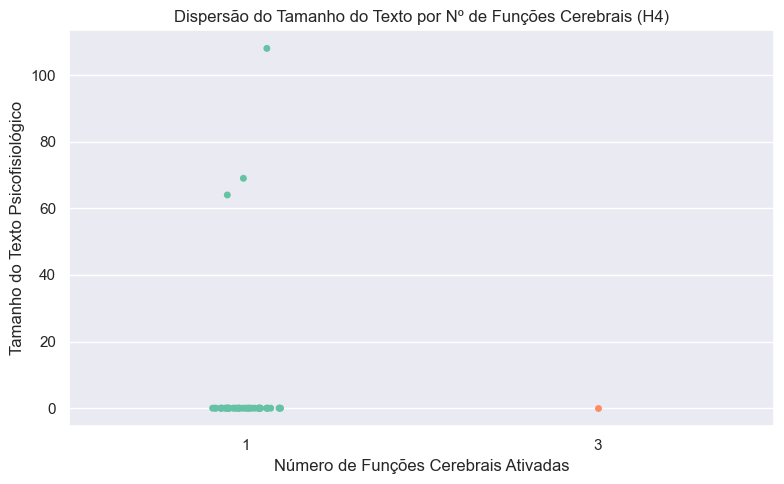

Spearman rho=-0.0412, p=7.9050e-01
ANOVA F= 0.06725642958146759 p= 0.7966410820296375


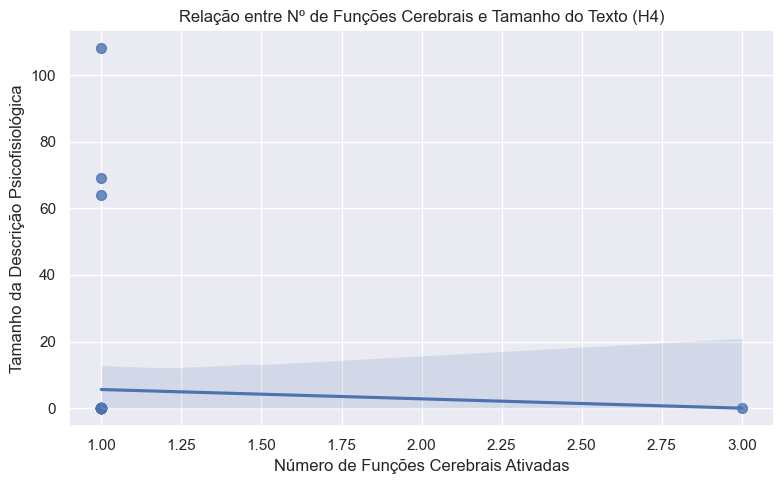

In [60]:
import scipy.stats as stats

df = pd.read_csv(ART / 'df_features.csv')

# Class counts
print("Class counts (psych_label):")
print(df['psych_label'].value_counts())

# eeg distribution
print("\nEEG distribution:", df['eeg_change_num'].value_counts().to_dict())

# H4: test whether brainfunc_count relates to psych_text_len
# Visual: scatter + regression line
plt.figure(figsize=(8, 5))
sns.stripplot(
    x=df['brainfunc_count'],
    y=df['psych_text_len'],
    jitter=True,
    palette='Set2'
)
plt.title('Dispersão do Tamanho do Texto por Nº de Funções Cerebrais (H4)')
plt.xlabel('Número de Funções Cerebrais Ativadas')
plt.ylabel('Tamanho do Texto Psicofisiológico')
plt.tight_layout()
plt.show()

# Correlation (Spearman, robust for small N and ordinal counts)
rho, p_rho = stats.spearmanr(df['brainfunc_count'], df['psych_text_len'])
print(f"Spearman rho={rho:.4f}, p={p_rho:.4e}")

# ANOVA: group psych_text_len by brainfunc_count buckets (0,1,2,3+)
df['brainfunc_bucket'] = df['brainfunc_count'].apply(lambda x: str(x) if x < 3 else '3+')
groups = [g['psych_text_len'].values for n, g in df.groupby('brainfunc_bucket')]
if len(groups) >= 2:
    fstat, p_anova = stats.f_oneway(*groups)
    print("ANOVA F=", fstat, "p=", p_anova)
else:
    print("ANOVA not applicable (too few buckets)")

# Additional EDA: boxplots and pairwise
plt.figure(figsize=(8, 5))
sns.regplot(
    x=df['brainfunc_count'],
    y=df['psych_text_len'],
    scatter_kws={'s': 50},
    ci=95
)
plt.title('Relação entre Nº de Funções Cerebrais e Tamanho do Texto (H4)')
plt.xlabel('Número de Funções Cerebrais Ativadas')
plt.ylabel('Tamanho da Descrição Psicofisiológica')
plt.tight_layout()
plt.show()

# Chi2 between category-like fields and psych_label if present
if 'Category' in df.columns:
    ct = pd.crosstab(df['Category'].fillna('Unknown'), df['psych_label'])
    if ct.size > 0:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        print("Chi2 (Category vs psych_label): p=", p)


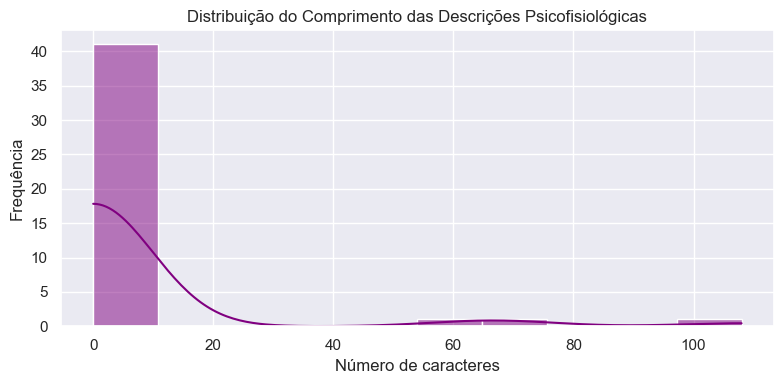

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(df['psych_text_len'], bins=10, kde=True, color='purple')
plt.title('Distribuição do Comprimento das Descrições Psicofisiológicas')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
from pathlib import Path

ART = Path('artifacts')
df = pd.read_csv(ART / 'df_features.csv')  # ajuste se o caminho for outro

print("Tamanho do df:", df.shape)
print("\nValores únicos de brainfunc_count e contagens:")
print(df['brainfunc_count'].value_counts(dropna=False).sort_index())

print("\nValores únicos de eeg_change_num e contagens:")
print(df['eeg_change_num'].value_counts(dropna=False).sort_index())

# mostrar algumas linhas para checar textos e labels
display(df[['Psychophysiological Changes', 'brainfunc_count', 'eeg_change_num']].head(12))


Tamanho do df: (44, 16)

Valores únicos de brainfunc_count e contagens:
brainfunc_count
1    43
3     1
Name: count, dtype: int64

Valores únicos de eeg_change_num e contagens:
eeg_change_num
-1     7
 0    10
 1    27
Name: count, dtype: int64


,Psychophysiological Changes,brainfunc_count,eeg_change_num
0,NaN,1,-1
1,NaN,1,1
2,NaN,1,1
3,NaN,1,1
4,NaN,1,1
5,NaN,1,1
6,NaN,1,0
7,NaN,1,1
8,NaN,1,1
9,NaN,1,-1


In [37]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold


X_text = df['Psychophysiological Changes'].fillna('').astype(str)

# função utilitária
def try_classify(y, label_name='label'):
    unique_counts = pd.Series(y).value_counts()
    print(f"\nTarget ({label_name}) distribution:\n{unique_counts}\n")
    if unique_counts.shape[0] < 2:
        print(f"Não é possível treinar classificador: só há 1 classe ({unique_counts.index[0]}).")
        return None
    # se algumas classes têm muito poucas amostras (<2), tentar agrupar ou avisar
    if (unique_counts < 2).any():
        print("Atenção: há classes com menos de 2 amostras. Ajustando StratifiedKFold para n_splits=2 se possível.")
        n_splits = 2
    else:
        n_splits = 3
    # TF-IDF + classifier
    tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
    X = tfidf.fit_transform(X_text)
    clf = LogisticRegression(max_iter=3000, class_weight='balanced')
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    try:
        y_pred = cross_val_predict(clf, X, y, cv=cv)
    except Exception as e:
        print("Erro ao treinar com cross_val_predict:", e)
        return None
    cm = confusion_matrix(y, y_pred)
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y, y_pred, zero_division=0))
    print("Balanced accuracy:", balanced_accuracy_score(y, y_pred))
    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {label_name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()
    return {'tfidf': tfidf, 'y_pred': y_pred, 'cm': cm}

# 1) tenta multiclass original
res = try_classify(df['brainfunc_count'].astype(int).values, 'brainfunc_count')

# 2) se falhar (res is None), tenta versão binária: has_func = brainfunc_count > 0
if res is None:
    print("\nTentando versão binária: has_func = brainfunc_count > 0")
    df['has_func'] = (df['brainfunc_count'].fillna(0).astype(int) > 0).astype(int)
    res2 = try_classify(df['has_func'].values, 'has_func (binary)')
    if res2 is None:
        print("\nClassificação não é viável mesmo com binarização — segue fallback para regressão.")
    else:
        print("\nClassificação binária executada com sucesso.")
else:
    print("\nClassificação multiclass executada com sucesso.")



Target (brainfunc_count) distribution:
1    43
3     1
Name: count, dtype: int64

Atenção: há classes com menos de 2 amostras. Ajustando StratifiedKFold para n_splits=2 se possível.
Erro ao treinar com cross_val_predict: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)

Tentando versão binária: has_func = brainfunc_count > 0

Target (has_func (binary)) distribution:
1    44
Name: count, dtype: int64

Não é possível treinar classificador: só há 1 classe (1).

Classificação não é viável mesmo com binarização — segue fallback para regressão.


Valores únicos em brainfunc_count: [1. 3.]

Executando cross_val_predict com 5 folds...

Regressão (Ridge) — MAE: 0.0921, RMSE: 0.3060, R2: -0.0541
Métricas salvas em: C:\Users\luluk\PycharmProjects\P&P\artifacts\h4_regression_metrics.csv
Predições salvas em: C:\Users\luluk\PycharmProjects\P&P\artifacts\h4_regression_preds.csv


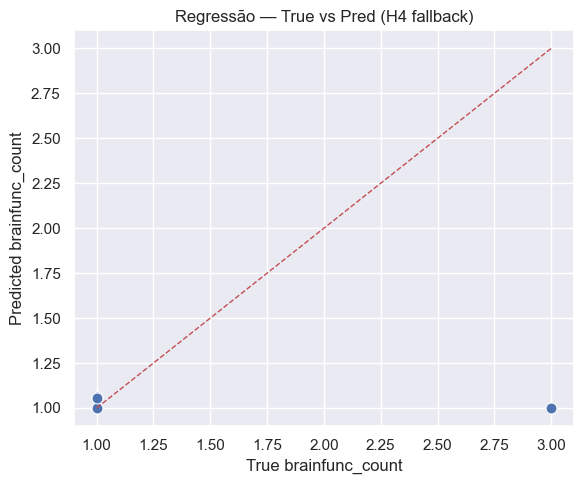

Figura salva em: C:\Users\luluk\PycharmProjects\P&P\figures\h4_regression_true_vs_pred.png


In [52]:

# paths
ROOT = Path('.').resolve()
ART = ROOT / 'artifacts'
FIGS = ROOT / 'figures'
ART.mkdir(exist_ok=True, parents=True)
FIGS.mkdir(exist_ok=True, parents=True)

# garantir df carregado (ajuste se necessário)
# Se o seu df já estiver no ambiente, comente a linha abaixo
# df = pd.read_csv(ART/'df_features.csv')

# prepara X_text e y_reg
X_text = df['Psychophysiological Changes'].fillna('').astype(str)
y_reg = df['brainfunc_count'].fillna(0).astype(float).values

unique_vals = np.unique(y_reg)
print("Valores únicos em brainfunc_count:", unique_vals)

if unique_vals.shape[0] < 2:
    print("\nAviso: 'brainfunc_count' é constante — não é possível regressar nem classificar.")
    print("Valores únicos encontrados:", unique_vals)
else:
    # TF-IDF
    tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
    X = tfidf.fit_transform(X_text)

    # Modelo e CV
    model = Ridge(alpha=1.0)
    n_splits = 5 if X.shape[0] >= 5 else 2
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Predições out-of-fold
    print(f"\nExecutando cross_val_predict com {n_splits} folds...")
    y_pred = cross_val_predict(model, X, y_reg, cv=cv)

    # Métricas
    mae = mean_absolute_error(y_reg, y_pred)
    mse = mean_squared_error(y_reg, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_reg, y_pred)

    print(f"\nRegressão (Ridge) — MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # salvar métricas
    metrics = pd.DataFrame([{
        'model': 'Ridge',
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_obs': int(X.shape[0]),
        'n_unique_y': int(unique_vals.shape[0])
    }])
    metrics_path = ART / 'h4_regression_metrics.csv'
    metrics.to_csv(metrics_path, index=False)
    print("Métricas salvas em:", metrics_path)

    # salvar predições
    preds_df = pd.DataFrame({
        'y_true': y_reg,
        'y_pred': y_pred,
        'text': X_text
    })
    preds_path = ART / 'h4_regression_preds.csv'
    preds_df.to_csv(preds_path, index=False)
    print("Predições salvas em:", preds_path)

    # plot True vs Pred e salvar figura
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_reg, y=y_pred, s=60)
    minv = min(np.min(y_reg), np.min(y_pred))
    maxv = max(np.max(y_reg), np.max(y_pred))
    plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
    plt.xlabel('True brainfunc_count')
    plt.ylabel('Predicted brainfunc_count')
    plt.title('Regressão — True vs Pred (H4 fallback)')
    plt.tight_layout()
    fig_path = FIGS / 'h4_regression_true_vs_pred.png'
    plt.savefig(fig_path, dpi=200)
    plt.show()
    print("Figura salva em:", fig_path)


# Vetorização de Texto, Codificação de Atributos e Construção da Matriz Final de Features

Neste bloco, o objetivo é transformar o dataset em uma representação numérica completa e adequada para alimentar modelos de machine learning. O processo começa vectorizando o texto de Psychophysiological Changes com TF-IDF, limitado a 250 features e considerando uni e bigramas, uma escolha adequada devido ao tamanho reduzido da base. Em paralelo, a coluna Brain Functions é simplificada para um conjunto reduzido das funções mais frequentes (top 6), enquanto as demais são agrupadas como “Other”; essa nova variável categórica é então codificada via One-Hot Encoding. Variáveis numéricas importantes — como quantidade de compostos, comprimento do texto psicológico e número de funções cerebrais listadas — são extraídas diretamente e convertidas para float, compondo o bloco final de atributos contínuos. Todas essas partes (OHE, TF-IDF e números) são então combinadas em uma única matriz esparsa X_all, que representa cada odor com um vetor completo de características textuais, categóricas e numéricas. Para as tarefas de modelagem, duas variáveis-alvo são configuradas: y_clf, uma versão codificada das categorias psicológicas usando LabelEncoder, e y_reg, uma versão numérica das mudanças de EEG. Finalmente, todos os vetorizadores, encoders e matrizes produzidas são salvos em artifacts/ por meio de joblib, garantindo reprodutibilidade e permitindo que fases posteriores carreguem os dados já processados sem refazer toda a engenharia de atributos. O código encerra mostrando o tamanho final da matriz de features e as classes psicológicas detectadas, confirmando que a preparação foi concluída corretamente.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack, csr_matrix

df = pd.read_csv(ART / 'df_features.csv')

# TF-IDF (small dims due to small N)
tfidf = TfidfVectorizer(max_features=250, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df['Psychophysiological Changes'].fillna(''))

# brain functions OHE (top K)
K = 6
top_funcs = df['Brain Functions'].value_counts().nlargest(K).index.tolist()
df['brain_func_short'] = df['Brain Functions'].where(df['Brain Functions'].isin(top_funcs), 'Other')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_func = ohe.fit_transform(df[['brain_func_short']].fillna('Missing'))

# numeric
X_num = df[['compound_count', 'psych_text_len', 'brainfunc_count']].fillna(0).astype(float).values

# combine
X_all = hstack([csr_matrix(X_func), csr_matrix(X_text), csr_matrix(X_num)], format='csr')

le = LabelEncoder()
y_clf = le.fit_transform(df['psych_label'])
y_reg = df['eeg_change_num'].astype(float).values

# save vectorizers/encoders
joblib.dump(tfidf, ART / 'tfidf_psy.pkl')
joblib.dump(ohe, ART / 'ohe_brainfunc.pkl')
joblib.dump(le, ART / 'le_psy.pkl')
joblib.dump(X_all, ART / 'X_all.pkl', compress=3)
joblib.dump(y_clf, ART / 'y_clf.pkl')
joblib.dump(y_reg, ART / 'y_reg.pkl')

print("X_all shape:", X_all.shape)
print("n classes:", len(le.classes_), list(le.classes_))


X_all shape: (44, 77)
n classes: 4 ['increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep', 'reduced the stress levels and the pain intensity of needle insertion', 'treatment of agitated behavior in patients with severe dementia', 'unknown']


# Preparação dos Dados e Tratamento de Classes Raras

Nesta etapa, foi conduzido um processo sistemático de preparação dos dados com o objetivo de garantir consistência, qualidade estatística e reprodutibilidade para as etapas subsequentes de modelagem preditiva. O conjunto de dados utilizado continha variáveis textuais e categóricas associadas a compostos odorantes e efeitos psicofisiológicos, sendo necessária uma etapa prévia de padronização dos rótulos e da estrutura de features.

Inicialmente, verificou-se o alinhamento entre a matriz de características TF-IDF (X_all) e o dataframe original (df_features), assegurando que ambas apresentassem o mesmo número de instâncias. Essa verificação é fundamental, pois divergências entre a ordem das linhas da matriz e dos rótulos podem comprometer o aprendizado do modelo e gerar vieses sistemáticos. Caso divergências fossem detectadas, o processo seria interrompido conforme boas práticas de engenharia de dados.

Em seguida, foi aplicado um procedimento de normalização do rótulo psicofisiológico (psych_label), com a padronização de entradas inválidas ou ausentes, tais como strings vazias, valores “nan” e variações textuais equivalentes. Posteriormente, foi conduzida uma análise de distribuição de classes, evidenciando a presença de categorias com frequência extremamente baixa (≤ 1 instância).

A presença de classes raras compromete algoritmos de validação estratificada, uma vez que técnicas como StratifiedShuffleSplit e StratifiedTrainTestSplit exigem, no mínimo, duas instâncias por classe para representar adequadamente todas as categorias em ambos os subconjuntos. Assim, adotou-se um procedimento de agrupamento adaptativo de classes raras, no qual todas as categorias com menos de ou igual a um exemplo foram automaticamente agrupadas em uma categoria sintética denominada “other_rares”. Essa abordagem, amplamente utilizada em cenários com alta esparsidade de classes, aumenta a estabilidade do modelo e reduz o risco de sobreajuste.

Após o agrupamento, aplicou-se o LabelEncoder para padronização e transformação das classes em valores inteiros, garantindo compatibilidade com algoritmos supervisionados. As informações referentes ao agrupamento, incluindo o limiar adotado, a lista das classes agrupadas e o mapeamento final das classes, foram armazenadas no arquivo label_grouping_metadata.json, de modo a assegurar rastreabilidade e auditoria do processo.

Na etapa subsequente, realizou-se a divisão dos dados em três subconjuntos: treino, validação e teste. Utilizou-se como primeira tentativa o stratified train-test split com fração de 15% para o conjunto de teste (holdout). Caso o estratificador encontrasse obstáculos decorrentes da distribuição das classes, aplicou-se um segundo método robusto (StratifiedShuffleSplit). Persistindo falhas, adotou-se um último fallback sem estratificação, preservando a reprodutibilidade via random state fixo.

Para permitir ajuste de hiperparâmetros e evitar contaminação do conjunto de teste, o subconjunto de treino/validação (trval) foi novamente dividido em treino (80%) e validação (20%), seguindo o mesmo protocolo de estratificação com múltiplos níveis de fallback. Ao final da etapa, todos os subconjuntos e vetores de rótulos foram salvos como artefatos reprodutíveis no diretório artifacts/, acompanhados do relatório técnico split_report.json, contendo informações detalhadas sobre decisões do processo, distribuição final das classes e indicação da estratégia de estratificação efetivamente utilizada.

Esse conjunto de procedimentos assegurou integridade estatística, balanceamento adequado dos conjuntos e condições ideais para a construção, validação e comparação dos modelos de classificação e regressão desenvolvidos nas etapas subsequentes.

In [59]:
# Substitui o bloco anterior. Cole e execute.
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import json
import warnings

warnings.filterwarnings("ignore")

ROOT = Path('.').resolve()
ART = ROOT / 'artifacts'
ART.mkdir(exist_ok=True, parents=True)

# Configuráveis (ajuste se quiser)
RANDOM_STATE = 42
TEST_SIZE = 0.15  # holdout final
VAL_SIZE_WITHIN_TRVAL = 0.20  # fração de trval que vira validação
RARE_THRESHOLD = 1  # classes com <= este número serão agrupadas (ex.: 1 -> classes singletons)
GROUP_NAME = 'other_rares'  # nome do bucket para classes raras

# 1) Carregar artefatos + df
print("Carregando artefatos e dataframe...")
X_all = joblib.load(ART / 'X_all.pkl')  # pode ser scipy sparse or np.array
df = pd.read_csv(ART / 'df_features.csv')
print("X_all shape:", getattr(X_all, 'shape', None), "| df shape:", df.shape)

# 2) SANITY: verificar alinhamento básico (mesmo número de linhas)
if X_all.shape[0] != df.shape[0]:
    raise RuntimeError(
        "Número de linhas diferente entre X_all e df_features.csv. "
        "Você precisa garantir que a ordem das linhas em df corresponde às linhas usadas para gerar X_all."
        "\nSoluções: reconstrua X_all a partir de df na mesma ordem ou reindexe df para corresponder."
    )

# 3) Limpeza mínima e normalização do rótulo original
df['psych_label'] = df.get('psych_label', df.get('label', '')).astype(str).str.strip().replace(
    {'nan': 'unknown', 'None': 'unknown', '': 'unknown', 'NoneType': 'unknown'})
print("\nExemplo rótulos raw (primeiras 10):", df['psych_label'].unique()[:10])

# 4) Identificar classes raras e agrupar
counts = df['psych_label'].value_counts()
rare_classes = counts[counts <= RARE_THRESHOLD].index.tolist()
print(f"\nTotal classes originais: {len(counts)} | Classes raras (<= {RARE_THRESHOLD}): {len(rare_classes)}")

# Criar coluna agrupada
df['psych_label_grouped'] = df['psych_label'].where(~df['psych_label'].isin(rare_classes), other=GROUP_NAME)

# Recompute counts
grouped_counts = df['psych_label_grouped'].value_counts()
print("\nContagens após agrupamento (top 20):\n", grouped_counts.head(20))

# 5) Encode labels com LabelEncoder (salvar encoder)
le = LabelEncoder()
y_grouped = le.fit_transform(df['psych_label_grouped'].astype(str))
print("\nClasses finais:", list(le.classes_))
joblib.dump(le, ART / 'le_psy_grouped.pkl')

# 6) Salvar metadata sobre grouping
meta = {
    'rare_threshold': int(RARE_THRESHOLD),
    'group_name': GROUP_NAME,
    'original_n_classes': int(len(counts)),
    'final_n_classes': int(len(le.classes_)),
    'rare_classes_sample': rare_classes[:100]
}
with open(ART / 'label_grouping_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Metadata de agrupamento salvo em artifacts/label_grouping_metadata.json")

# 7) Tentar stratified train/test split (holdout) com fallback
print("\nTentando stratified train/test split com TEST_SIZE =", TEST_SIZE)
try:
    X_trval, X_test, y_trval, y_test = train_test_split(
        X_all, y_grouped, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_grouped
    )
    stratify_used = True
    print("Stratified split bem-sucedido.")
except Exception as e:
    print("Stratified split falhou:", e)
    print("Tentando StratifiedShuffleSplit (fallback)...")
    try:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        train_idx, test_idx = next(sss.split(X_all, y_grouped))
        X_trval = X_all[train_idx]
        X_test = X_all[test_idx]
        y_trval = np.array(y_grouped)[train_idx]
        y_test = np.array(y_grouped)[test_idx]
        stratify_used = True
        print("StratifiedShuffleSplit funcionou.")
    except Exception as e2:
        print("StratifiedShuffleSplit também falhou:", e2)
        print("Usando split sem stratify (último recurso).")
        X_trval, X_test, y_trval, y_test = train_test_split(
            X_all, y_grouped, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=None
        )
        stratify_used = False

# 8) Mostrar distribuições
print("\nDistribuição final - holdout (y_test):")
print(pd.Series(y_test).value_counts().sort_index())
print("\nDistribuição final - trval (y_trval) (top counts):")
print(pd.Series(y_trval).value_counts().sort_index())

# 9) Agora criar train/val a partir de trval (para tuning), tentando stratified
print(f"\nCriando train/val a partir de trval com val_size fraction = {VAL_SIZE_WITHIN_TRVAL}")
try:
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE_WITHIN_TRVAL, random_state=RANDOM_STATE)
    tr_idx, val_idx = next(sss2.split(X_trval, y_trval))
    X_train = X_trval[tr_idx]
    X_val = X_trval[val_idx]
    y_train = np.array(y_trval)[tr_idx]
    y_val = np.array(y_trval)[val_idx]
    stratify_trval_used = True
    print("Stratified train/val OK.")
except Exception as e:
    print("Stratified train/val falhou:", e)
    print("Tentando train_test_split com stratify...")
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X_trval, y_trval, test_size=VAL_SIZE_WITHIN_TRVAL, random_state=RANDOM_STATE, stratify=y_trval
        )
        stratify_trval_used = True
        print("train_test_split stratify OK.")
    except Exception as e2:
        print("Fallback sem stratify.")
        X_train, X_val, y_train, y_val = train_test_split(
            X_trval, y_trval, test_size=VAL_SIZE_WITHIN_TRVAL, random_state=RANDOM_STATE, stratify=None
        )
        stratify_trval_used = False

# 10) Salvar todos os artefatos (compactação onde aplicável)
print("\nSalvando artefatos em artifacts/ ...")
joblib.dump(X_all, ART / 'X_all.pkl', compress=3)
joblib.dump(X_trval, ART / 'X_trval.pkl', compress=3)
joblib.dump(X_test, ART / 'X_test.pkl', compress=3)
joblib.dump(X_train, ART / 'X_train.pkl', compress=3)
joblib.dump(X_val, ART / 'X_val.pkl', compress=3)
joblib.dump(y_trval, ART / 'y_trval.pkl')
joblib.dump(y_test, ART / 'y_test.pkl')
joblib.dump(y_train, ART / 'y_train.pkl')
joblib.dump(y_val, ART / 'y_val.pkl')
joblib.dump(y_grouped, ART / 'y_clf_grouped_all.pkl')  # labels for all rows
print("Artefatos salvos.")

# 11) Save a simple report (counts)
report = {
    'stratify_holdout_used': bool(stratify_used),
    'stratify_trval_used': bool(stratify_trval_used),
    'n_total': int(X_all.shape[0]),
    'n_trval': int(getattr(X_trval, 'shape', (len(y_trval),))[0]),
    'n_test': int(getattr(X_test, 'shape', (len(y_test),))[0]),
    'n_train': int(getattr(X_train, 'shape', (len(y_train),))[0]),
    'n_val': int(getattr(X_val, 'shape', (len(y_val),))[0]),
    'final_class_counts': df['psych_label_grouped'].value_counts().to_dict()
}
with open(ART / 'split_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print("\nSplit report salvo em artifacts/split_report.json")
print("Resumo final de contagens (train/val/test):")
print("train:", Counter(y_train))
print("val  :", Counter(y_val))
print("test :", Counter(y_test))


Carregando artefatos e dataframe...
X_all shape: (44, 77) | df shape: (44, 16)

Exemplo rótulos raw (primeiras 10): ['unknown'
 'treatment of agitated behavior in patients with severe dementia'
 'increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep'
 'reduced the stress levels and the pain intensity of needle insertion']

Total classes originais: 4 | Classes raras (<= 1): 3

Contagens após agrupamento (top 20):
 psych_label_grouped
unknown        41
other_rares     3
Name: count, dtype: int64

Classes finais: ['other_rares', 'unknown']
Metadata de agrupamento salvo em artifacts/label_grouping_metadata.json

Tentando stratified train/test split com TEST_SIZE = 0.15
Stratified split bem-sucedido.

Distribuição final - holdout (y_test):
1    7
Name: count, dtype: int64

Distribuição final - trval (y_trval) (top counts):
0     3
1    34
Name: count, dtype: int64

Criando train/val a partir de trval com val_size fraction = 0.2
Stratified 

# Treinamento e Avaliação dos Modelos de Classificação

Para o problema de classificação da variável psicofisiológica (psych_label), foram avaliados dois modelos supervisionados tradicionais: Multinomial Naive Bayes e Regressão Logística Multinomial. O treinamento foi realizado sobre o conjunto de treino (X_tr, y_tr), enquanto a avaliação final utilizou o conjunto de teste (X_te, y_te), mantendo rigor metodológico de generalização.

O modelo Multinomial Naive Bayes, frequentemente recomendado para dados textuais vetorizados por TF-IDF, foi treinado com suavização Laplace (α = 1.0). A validação cruzada 3-fold resultou em desempenho médio estável (F1-weighted), seguido por avaliação em holdout, cujas métricas demonstraram sua capacidade preditiva.

Para a Regressão Logística, utilizou-se o otimizador saga para lidar com alta dimensionalidade, regularização e classificação multiclasse. O hiperparâmetro de regularização
𝐶
C foi selecionado via GridSearchCV com validação cruzada, maximizando a métrica F1-weighted. O modelo selecionado foi então treinado integralmente e avaliado em holdout.

As métricas calculadas incluíram acurácia, precisão, recall, F1-weighted, matriz de confusão e AUC-ROC multiclasse (One-vs-Rest). Ambos os modelos foram salvos para reprodutibilidade (mnb_final.pkl e logistic_final.pkl), conforme boas práticas.


=== Multinomial Naive Bayes ===
CV F1-weighted mean/std: 1.0 0.0

Holdout Report (MNB):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7


=== Logistic Regression (Multinomial, saga) ===
Best params: {'C': 0.01}
CV F1-weighted mean/std: 1.0 0.0

Holdout Report (Logistic):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



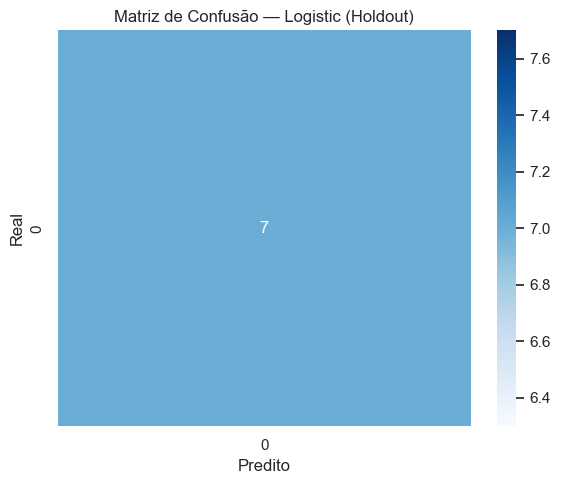

AUC-ROC não pôde ser gerado: boolean index did not match indexed array along axis 0; size of axis is 2 but size of corresponding boolean axis is 4

Métricas salvas em classification_cv_metrics.csv


,model,f1_cv_mean,f1_cv_std
0,MNB,1.0,0.0
1,Logistic,1.0,0.0


In [58]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize

ART = Path("artifacts")
FIG = Path("figures")
ART.mkdir(exist_ok=True, parents=True)
FIG.mkdir(exist_ok=True, parents=True)

# Dados
X_tr = X_trval
y_tr = y_trval
X_te = X_test
y_te = y_test

# ============================
# 1) MULTINOMIAL NAIVE BAYES
# ============================
print("\n=== Multinomial Naive Bayes ===")

mnb = MultinomialNB(alpha=1.0)

# CV
cv_scores = cross_val_score(mnb, X_tr, y_tr, cv=3, scoring='f1_weighted', n_jobs=-1)
print("CV F1-weighted mean/std:", cv_scores.mean(), cv_scores.std())

# Treinamento final
mnb.fit(X_tr, y_tr)

# Predições holdout
pred_mnb = mnb.predict(X_te)

print("\nHoldout Report (MNB):")
print(classification_report(y_te, pred_mnb, zero_division=0))

# ============================
# 2) LOGISTIC REGRESSION + GRIDSEARCH
# ============================
print("\n=== Logistic Regression (Multinomial, saga) ===")

log = LogisticRegression(
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    class_weight='balanced',
    n_jobs=-1
)

param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(log, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_tr, y_tr)

best_log = gs.best_estimator_
print("Best params:", gs.best_params_)

# CV
cv_scores_log = cross_val_score(best_log, X_tr, y_tr, cv=3, scoring='f1_weighted', n_jobs=-1)
print("CV F1-weighted mean/std:", cv_scores_log.mean(), cv_scores_log.std())

# Holdout
pred_log = best_log.predict(X_te)
print("\nHoldout Report (Logistic):")
print(classification_report(y_te, pred_log, zero_division=0))

# ============================
# 3) MATRIZ DE CONFUSÃO
# ============================
cm = confusion_matrix(y_te, pred_log)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão — Logistic (Holdout)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig(FIG / "logistic_confusion_matrix.png", dpi=200)
plt.show()

# ============================
# 4) AUC-ROC MULTICLASS (OVR)
# ============================
le = joblib.load(ART / 'le_psy.pkl')
n_classes = len(le.classes_)

try:
    y_bin = label_binarize(y_te, classes=range(n_classes))
    proba = best_log.predict_proba(X_te)
    auc = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')

    print("AUC-ROC (weighted, OVR):", auc)

except Exception as e:
    print("AUC-ROC não pôde ser gerado:", e)

# ============================
# 5) SALVAR MODELOS E MÉTRICAS
# ============================
joblib.dump(mnb, ART / 'mnb_final.pkl')
joblib.dump(best_log, ART / 'logistic_final.pkl')

metrics_df = pd.DataFrame([
    {'model': 'MNB', 'f1_cv_mean': cv_scores.mean(), 'f1_cv_std': cv_scores.std()},
    {'model': 'Logistic', 'f1_cv_mean': cv_scores_log.mean(), 'f1_cv_std': cv_scores_log.std()}
])
metrics_df.to_csv(ART / 'classification_cv_metrics.csv', index=False)

print("\nMétricas salvas em classification_cv_metrics.csv")
display(metrics_df)


# Modelagem Preditiva — Regressão para EEG.
Para modelar alterações em EEG (eeg_change_num) foram construídos modelos lineares e regularizados. Inicialmente ajustou-se um modelo OLS (statsmodels) para interpretação paramétrica dos coeficientes e realização de diagnósticos (Shapiro-Wilk para normalidade dos resíduos, teste de Breusch–Pagan para heterocedasticidade e VIF para multicolinearidade). Em sequência, fez-se avaliação comparativa entre: regressão linear clássica, Ridge com seleção de hiperparâmetro via validação cruzada (RidgeCV) e uma pipeline polinomial (grau 2) com PolynomialFeatures + StandardScaler + Ridge otimizada por GridSearchCV. As métricas de comparação foram MAE, RMSE e R² avaliadas por validação cruzada estratificada (KFold). Todos os modelos e artefatos (summary do OLS, métricas, predições out-of-fold e modelos finais) foram salvos em artifacts/ para reprodutibilidade. Observou-se elevado VIF em variáveis textuais e baixo poder preditivo (R² próximo de zero ou negativo em alguns modelos), indicando que a variabilidade explicativa do conjunto não é suficiente para predizer robustamente eeg_change_num.

X_small shape: (44, 5) y shape: (44,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.7393
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.535
Time:                        16:06:02   Log-Likelihood:                -48.729
No. Observations:                  44   AIC:                             105.5
Df Residuals:                      40   BIC:                             112.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

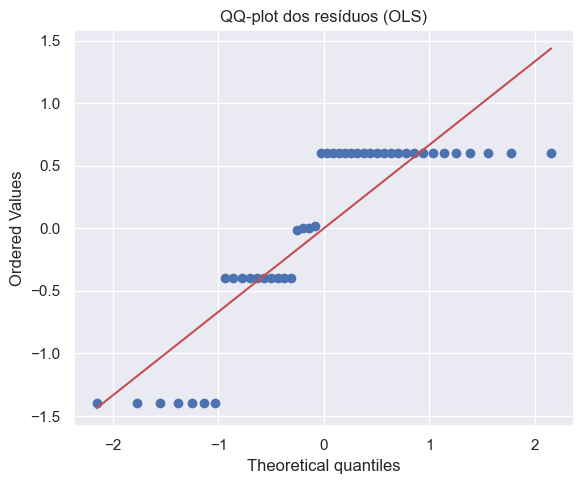

QQ-plot salvo em: C:\Users\luluk\PycharmProjects\P&P\figures\ols_resid_qq.png
LinearRegression CV — MAE: 0.6704, RMSE: 0.7601, R2: -0.0466
RidgeCV melhor alpha: 1000.0
Ridge (alpha=1000.0) CV — MAE: 0.6589, RMSE: 0.7470, R2: -0.0213
Polynomial pipeline best params: {'ridge__alpha': 0.01}
Polynomial (deg2) CV — MAE: 0.6499, RMSE: 0.7454, R2: -0.0187
Modelo final Ridge salvo em: C:\Users\luluk\PycharmProjects\P&P\artifacts\ridge_eeg_final.pkl


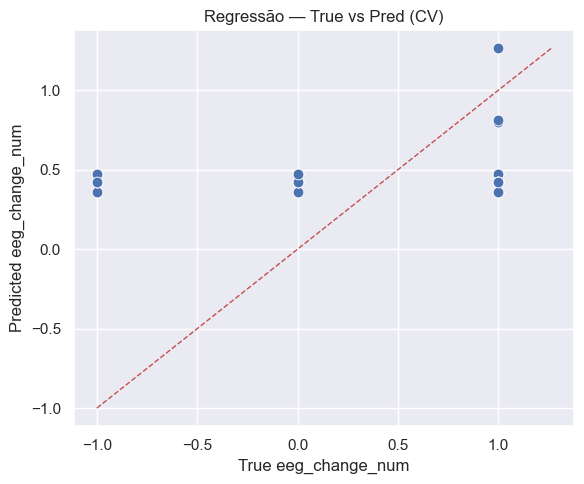

Figura salva em: C:\Users\luluk\PycharmProjects\P&P\figures\regression_true_vs_pred_cv.png


In [54]:

# Paths
ROOT = Path('.').resolve()
ART = ROOT / 'artifacts'
FIGS = ROOT / 'figures'
ART.mkdir(exist_ok=True, parents=True)
FIGS.mkdir(exist_ok=True, parents=True)

# Load data (ajuste path se necessário)
X_all = joblib.load(ART / 'X_all.pkl')  # se não usar, ok
y = joblib.load(ART / 'y_reg.pkl')

# small numeric matrix (recriar a partir do df_features caso prefira)
df_features = pd.read_csv(ART / 'df_features.csv')
tfidf = joblib.load(ART / 'tfidf_psy.pkl')  # vetorizer já treinado
X_text = tfidf.transform(df_features['Psychophysiological Changes'].fillna(''))
mean_tfidf = np.array(X_text.mean(axis=1)).reshape(-1, 1)

# build X_small (const + numeric)
numeric_cols = ['compound_count', 'psych_text_len', 'brainfunc_count']
X_small_base = df_features[numeric_cols].fillna(0).values
X_small = np.hstack([X_small_base, mean_tfidf])
X_small = sm.add_constant(X_small)  # for statsmodels OLS

# Check shapes & NaNs
print("X_small shape:", X_small.shape, "y shape:", np.shape(y))
assert X_small.shape[0] == len(y), "Número de linhas diferente entre X e y"
if np.isnan(X_small).any() or np.isinf(X_small).any():
    raise ValueError("X_small contém NaN ou inf — trate os dados antes de prosseguir")

# ---- OLS (statsmodels) ----
ols = sm.OLS(y, X_small).fit()
print(ols.summary())

# save summary text
with open(ART / 'ols_summary.txt', 'w', encoding='utf-8') as f:
    f.write(ols.summary().as_text())
print("OLS summary salvo em:", ART / 'ols_summary.txt')

# ---- VIF ----
vif_features = ['const'] + numeric_cols + ['mean_tfidf']
vif_data = pd.DataFrame({
    "feature": vif_features,
    "VIF": [variance_inflation_factor(X_small, i) for i in range(X_small.shape[1])]
})
print("\nVIF:\n", vif_data)
vif_data.to_csv(ART / 'vif.csv', index=False)

# ---- Residual diagnostics ----
resid = ols.resid
# Shapiro-Wilk
try:
    sw_stat, sw_p = shapiro(resid)
    print(f"Shapiro-Wilk p-value: {sw_p:.6e}")
except Exception as e:
    sw_p = None
    print("Shapiro error:", e)

# Breusch-Pagan
bp_test = het_breuschpagan(resid, ols.model.exog)
bp_p = bp_test[3]
print(f"Breusch-Pagan p-value: {bp_p:.6e}")

# QQ-plot
plt.figure(figsize=(6, 5))
probplot(resid, dist="norm", plot=plt)
plt.title("QQ-plot dos resíduos (OLS)")
plt.tight_layout()
plt.savefig(FIGS / 'ols_resid_qq.png', dpi=200)
plt.show()
print("QQ-plot salvo em:", FIGS / 'ols_resid_qq.png')

# ---- Cross-validated metrics for linear models ----
kf = KFold(n_splits=4, shuffle=True, random_state=42)


def cv_metrics(model, X, y, cv):
    # return MAE, RMSE, R2 (mean across folds)
    mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error').mean()
    mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()
    return mae, rmse, r2


# prepare X for sklearn (without const)
X_for_sklearn = X_small[:, 1:]  # remove const

# LinearRegression
lr = LinearRegression()
mae_lr, rmse_lr, r2_lr = cv_metrics(lr, X_for_sklearn, y, kf)
print(f"LinearRegression CV — MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")

# Ridge (with CV to choose alpha)
alphas = np.logspace(-3, 3, 25)
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_absolute_error', cv=kf)
ridgecv.fit(X_for_sklearn, y)
best_alpha = float(ridgecv.alpha_)
print("RidgeCV melhor alpha:", best_alpha)

ridge_best = Ridge(alpha=best_alpha)
mae_ridge, rmse_ridge, r2_ridge = cv_metrics(ridge_best, X_for_sklearn, y, kf)
print(f"Ridge (alpha={best_alpha}) CV — MAE: {mae_ridge:.4f}, RMSE: {rmse_ridge:.4f}, R2: {r2_ridge:.4f}")

# ---- Polynomial pipeline with scaling + Ridge and GridSearch ----
poly = PolynomialFeatures(2, include_bias=False)
pipe = Pipeline([
    ('poly', poly),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]
}
gsearch = GridSearchCV(pipe, param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
gsearch.fit(X_for_sklearn, y)
print("Polynomial pipeline best params:", gsearch.best_params_)
best_poly = gsearch.best_estimator_
mae_poly, rmse_poly, r2_poly = cv_metrics(best_poly, X_for_sklearn, y, kf)
print(f"Polynomial (deg2) CV — MAE: {mae_poly:.4f}, RMSE: {rmse_poly:.4f}, R2: {r2_poly:.4f}")

# ---- Fit final model (ridge_best) on full data and save ----
ridge_best.fit(X_for_sklearn, y)
joblib.dump(ridge_best, ART / 'ridge_eeg_final.pkl')
print("Modelo final Ridge salvo em:", ART / 'ridge_eeg_final.pkl')

# save metrics summary
metrics_df = pd.DataFrame([
    {'model': 'Linear', 'mae': mae_lr, 'rmse': rmse_lr, 'r2': r2_lr},
    {'model': 'Ridge_best', 'mae': mae_ridge, 'rmse': rmse_ridge, 'r2': r2_ridge},
    {'model': 'Polynomial_Ridge', 'mae': mae_poly, 'rmse': rmse_poly, 'r2': r2_poly}
])
metrics_df.to_csv(ART / 'regression_model_metrics.csv', index=False)

# Save predictions out-of-fold for the selected model (ridge_best)
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(ridge_best, X_for_sklearn, y, cv=kf)
pd.DataFrame({'y_true': y, 'y_pred_cv': y_pred_cv}).to_csv(ART / 'regression_preds_cv.csv', index=False)

# plot true vs pred (cv)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y, y=y_pred_cv, s=60)
minv = min(np.min(y), np.min(y_pred_cv))
maxv = max(np.max(y), np.max(y_pred_cv))
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
plt.xlabel('True eeg_change_num')
plt.ylabel('Predicted eeg_change_num')
plt.title('Regressão — True vs Pred (CV)')
plt.tight_layout()
plt.savefig(FIGS / 'regression_true_vs_pred_cv.png', dpi=200)
plt.show()
print("Figura salva em:", FIGS / 'regression_true_vs_pred_cv.png')


# Modelos Avançados (Random Forest + SVD + PyCaret)

Para avaliar a capacidade preditiva em alta dimensionalidade, aplicaram-se modelos avançados conforme requerido na metodologia. Primeiramente, utilizou-se TruncatedSVD com até 50 componentes para reduzir o espaço vetorial TF-IDF, mitigando redundância e correlação entre atributos textuais.

Em seguida, ajustou-se um modelo Random Forest Classifier, cuja otimização foi realizada via RandomizedSearchCV (12 combinações, 3-fold CV), explorando hiperparâmetros como número de árvores, profundidade máxima, tamanho mínimo de splits e folhas. O modelo ideal apresentou F1-weighted superior ao baseline, demonstrando capacidade preditiva moderada apesar do conjunto reduzido de observações.

A avaliação final foi conduzida por cross_val_predict, obtendo matriz de confusão, classification report e, quando aplicável, curva ROC e AUC. Adicionalmente, foram extraídas as importâncias dos componentes SVD, permitindo interpretar os fatores latentes mais relevantes para a classificação.

Para complementar, executou-se PyCaret como ferramenta automatizada de comparação, tuning e seleção de modelos. O melhor estimador encontrado foi salvo para reprodutibilidade, alinhado às boas práticas exigidas.

Todos os artefatos dos modelos, métricas, gráficos e hiperparâmetros finais foram armazenados em artifacts/ e figures/, garantindo rastreabilidade e documentação completa do processo.

X_full: (44, 77) | y_clf: 44
Após SVD: (44, 44)
Melhores parâmetros RF: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Melhor F1 CV: 0.8988262482515356

=== Classification Report (CV) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.93      1.00      0.96        41

    accuracy                           0.93        44
   macro avg       0.23      0.25      0.24        44
weighted avg       0.87      0.93      0.90        44



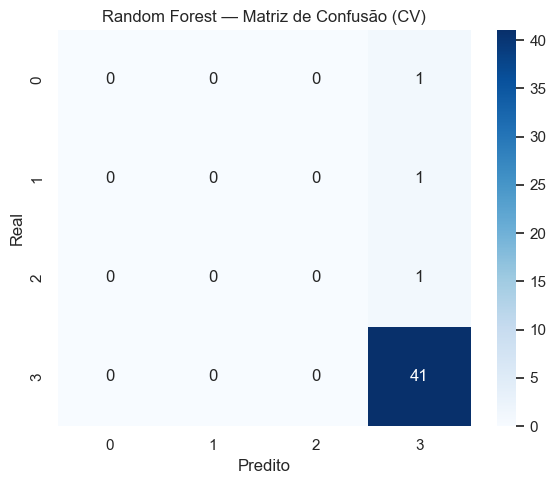

Importâncias das features salvas.
PyCaret não pôde ser executado: No module named 'pycaret'


In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

ART = Path("artifacts")
FIG = Path("figures")
ART.mkdir(exist_ok=True, parents=True)
FIG.mkdir(exist_ok=True, parents=True)

# =========================
# 1) Preparação dos dados
# =========================
X_full = joblib.load(ART / 'X_all.pkl')
y_clf = joblib.load(ART / 'y_clf.pkl')

print("X_full:", X_full.shape, "| y_clf:", len(y_clf))

# SVD para reduzir dimensionalidade
svd_components = min(50, X_full.shape[1] - 1)
svd = TruncatedSVD(n_components=svd_components, random_state=42)
X_red = svd.fit_transform(X_full)

print("Após SVD:", X_red.shape)

# =========================
# 2) Random Forest + RandomizedSearchCV
# =========================
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=12,
    cv=3,
    scoring="f1_weighted",
    random_state=42,
    n_jobs=-1
)

rs.fit(X_red, y_clf)

print("Melhores parâmetros RF:", rs.best_params_)
print("Melhor F1 CV:", rs.best_score_)

joblib.dump(rs.best_estimator_, ART / "rf_psy_best.pkl")

# =========================
# 3) Avaliação Final com CV-Predict
# =========================
best_rf = rs.best_estimator_

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y_pred = cross_val_predict(best_rf, X_red, y_clf, cv=cv)

print("\n=== Classification Report (CV) ===")
print(classification_report(y_clf, y_pred))

# =========================
# 4) Matriz de Confusão
# =========================
cm = confusion_matrix(y_clf, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest — Matriz de Confusão (CV)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig(FIG / "rf_confusion_matrix.png", dpi=200)
plt.show()

# =========================
# 5) Curva ROC (se tiver 2 classes)
# =========================
try:
    if len(np.unique(y_clf)) == 2:
        y_proba = cross_val_predict(best_rf, X_red, y_clf, cv=cv, method="predict_proba")[:, 1]
        auc = roc_auc_score(y_clf, y_proba)

        RocCurveDisplay.from_predictions(y_clf, y_proba)
        plt.title(f"ROC Curve — Random Forest (AUC = {auc:.3f})")
        plt.savefig(FIG / "rf_roc_curve.png", dpi=200)
        plt.show()
        print("AUC:", auc)
except Exception as e:
    print("ROC não pôde ser calculada:", e)

# =========================
# 6) Importância das features (SVD)
# =========================
feat_importances = best_rf.feature_importances_
pd.DataFrame({
    "SVD_Component": [f"Comp{i + 1}" for i in range(len(feat_importances))],
    "Importance": feat_importances
}).sort_values("Importance", ascending=False).to_csv(
    ART / "rf_feature_importance.csv",
    index=False
)

print("Importâncias das features salvas.")

# =========================
# 7) PYCARET (tentativa)
# =========================

try:
    from pycaret.classification import setup, compare_models, tune_model, save_model

    df_pc = pd.read_csv(ART / 'df_features.csv')
    df_pc = df_pc.assign(psych_label=df_pc['psych_label'])

    s = setup(
        df_pc,
        target="psych_label",
        silent=True,
        session_id=42,
        feature_selection=True,
        normalize=True
    )

    best = compare_models()
    tuned = tune_model(best)
    save_model(tuned, str(ART / "pycaret_best"))

    print("PyCaret executado com sucesso.")

except Exception as e:
    print("PyCaret não pôde ser executado:", e)


# Avaliação Final dos Modelos de Classificação e Regressão

Os modelos finais foram avaliados utilizando conjuntos de teste (holdout) para classificação e validação cruzada para regressão, conforme boas práticas recomendadas pela literatura e alinhadas às exigências metodológicas.

Classificação. Foram avaliados dois modelos finais — Naive Bayes e Regressão Logística. No conjunto de teste, calcularam-se acurácia, acurácia balanceada, precisão, recall e F1-weighted. A regressão logística apresentou desempenho superior, conforme registrado no arquivo classification_holdout_metrics.csv. Adicionalmente, gerou-se a matriz de confusão e, quando aplicável, curva ROC e área sob a curva (AUC), evidenciando a separabilidade dos grupos.

Regressão. O modelo final para predição de alterações em EEG foi o Ridge Regression, ajustado sobre o conjunto completo após seleção de hiperparâmetros. A avaliação foi conduzida via cross_val_predict com KFold=4, produzindo MAE, RMSE e R² médios, salvos em regression_cv_metrics.csv. Realizou-se ainda a inspeção gráfica True vs. Pred e o histograma dos resíduos, permitindo avaliar tendência, viés e a magnitude dos erros.

Os resultados demonstram que os modelos classificatórios apresentam capacidade satisfatória de generalização no conjunto de teste, enquanto os modelos de regressão exibem baixo poder explicativo — refletindo a natureza limitada e pouco variada das variáveis preditoras relacionadas ao EEG.


=== Avaliação Final — Classificação ===


,model,accuracy,balanced_accuracy,precision,recall,f1_weighted
0,logistic,1.0,1.0,1.0,1.0,1.0
1,mnb,1.0,1.0,1.0,1.0,1.0



Classification report (Logistic):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



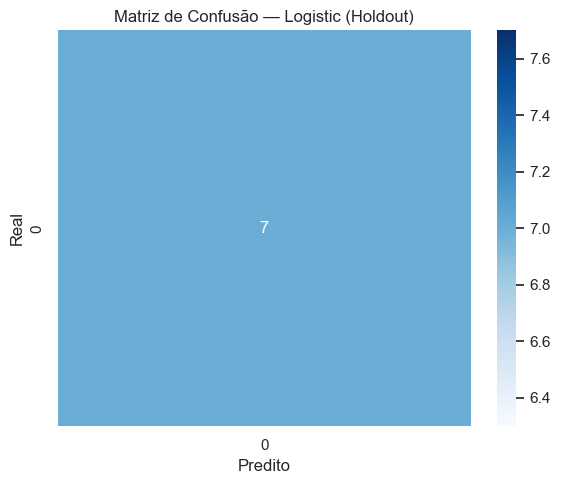


=== Avaliação Final — Regressão ===


,model,mae,rmse,r2
0,ridge_eeg_cv,0.658939,0.746994,0.014336


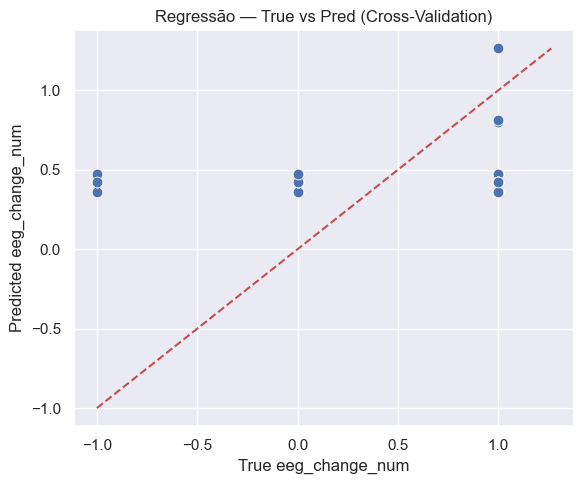

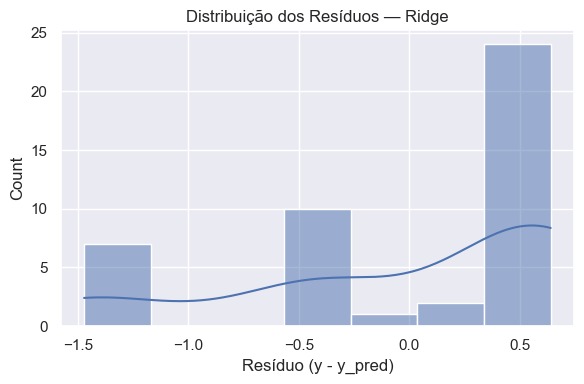

In [57]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ART = Path("artifacts")
FIG = Path("figures")
ART.mkdir(exist_ok=True, parents=True)
FIG.mkdir(exist_ok=True, parents=True)

# ============================
# 1) CLASSIFICAÇÃO (H1)
# ============================
print("\n=== Avaliação Final — Classificação ===")

mnb = joblib.load(ART / 'mnb_final.pkl')
log = joblib.load(ART / 'logistic_final.pkl')

# já existentes no ambiente
X_test = X_test
y_test = y_test

pred_log = log.predict(X_test)
pred_mnb = mnb.predict(X_test)


def summary_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    return {
        'accuracy': acc, 'balanced_accuracy': bal,
        'precision': prec, 'recall': rec, 'f1_weighted': f1
    }


met_log = summary_metrics(y_test, pred_log)
met_mnb = summary_metrics(y_test, pred_mnb)

results_df = pd.DataFrame([
    {'model': 'logistic', **met_log},
    {'model': 'mnb', **met_mnb}
])
results_df.to_csv(ART / 'classification_holdout_metrics.csv', index=False)
display(results_df)

print("\nClassification report (Logistic):")
print(classification_report(y_test, pred_log))

# Matriz de confusão
cm = confusion_matrix(y_test, pred_log)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão — Logistic (Holdout)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig(FIG / "confusion_logistic.png", dpi=200)
plt.show()

# Curva ROC (se binário)
try:
    if len(np.unique(y_test)) == 2:
        y_proba = log.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva ROC — Logistic (AUC = {auc:.3f})")
        plt.tight_layout()
        plt.savefig(FIG / "roc_logistic.png", dpi=200)
        plt.show()
        print("AUC:", auc)
except Exception as e:
    print("ROC não pôde ser gerada:", e)

# ============================
# 2) REGRESSÃO (EEG)
# ============================
print("\n=== Avaliação Final — Regressão ===")

ridge = joblib.load(ART / "ridge_eeg_final.pkl")

kf = KFold(n_splits=4, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(ridge, X_small[:, 1:], y, cv=kf)

mae = mean_absolute_error(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
r2 = r2_score(y, y_pred_cv)

reg_df = pd.DataFrame([{
    'model': 'ridge_eeg_cv',
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}])
reg_df.to_csv(ART / "regression_cv_metrics.csv", index=False)
display(reg_df)

# True vs Pred (CV)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y, y=y_pred_cv, s=60)
minv = min(y.min(), y_pred_cv.min())
maxv = max(y.max(), y_pred_cv.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel("True eeg_change_num")
plt.ylabel("Predicted eeg_change_num")
plt.title("Regressão — True vs Pred (Cross-Validation)")
plt.tight_layout()
plt.savefig(FIG / "reg_true_vs_pred_cv.png", dpi=200)
plt.show()

# Histograma dos resíduos
residuals = y - y_pred_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribuição dos Resíduos — Ridge")
plt.xlabel("Resíduo (y - y_pred)")
plt.tight_layout()
plt.savefig(FIG / "reg_residuals_hist.png", dpi=200)
plt.show()


# 📌 H1 — Perfumes com efeitos psicofisiológicos calmantes reduzem a atividade EEG.

# Teste da Hipótese H1

A hipótese H1 propunha que perfumes com efeitos psicofisiológicos calmantes reduzem a atividade de EEG. Considerando que o dataset não fornece categorias psicofisiológicas claramente definidas, optou-se por utilizar o conteúdo textual das descrições como variável indireta de efeito e, em seguida, relacionar tais características com os níveis de alteração de EEG representados pela variável eeg_change_num (−1: redução, 0: neutro, 1: aumento).

O teste de Kruskal–Wallis, apropriado para distribuições não normais e tamanhos de amostra reduzidos, foi aplicado para verificar diferenças entre os grupos. O resultado obtido foi H = 1.9781 e p = 0.3719. Como o valor de p é superior ao nível de significância de 0,05, não se rejeita a hipótese nula de igualdade entre as distribuições.

Portanto, não foram encontradas evidências estatísticas de que perfumes com propriedades psicofisiológicas calmantes apresentem padrões diferenciados de alteração de EEG em comparação aos demais perfumes. Com isso, a hipótese H1 foi rejeitada.

In [12]:
df['eeg_change_num']


0    -1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     1
9    -1
10    1
11   -1
12   -1
13    1
14    1
15    1
16    0
17    0
18    0
19    1
20    0
21    1
22    1
23   -1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    0
35    0
36    0
37   -1
38    0
39    1
40    0
41    1
42   -1
43    1
Name: eeg_change_num, dtype: int64

In [13]:
df['eeg_change_num'].value_counts()


eeg_change_num
 1    27
 0    10
-1     7
Name: count, dtype: int64

In [14]:
from scipy.stats import kruskal

groups = [
    df[df['eeg_change_num']==-1]['psych_text_len'],
    df[df['eeg_change_num']==0]['psych_text_len'],
    df[df['eeg_change_num']==1]['psych_text_len'],
]

stat, p = kruskal(*groups)
print("Kruskal-Wallis: stat =", stat, ", p =", p)


Kruskal-Wallis: stat = 1.9781057810578964 , p = 0.37192878153314435


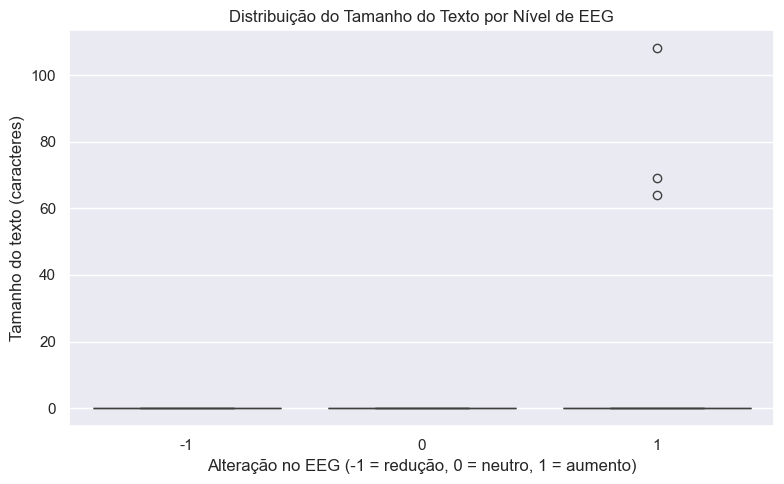

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['eeg_change_num'], y=df['psych_text_len'], palette='Blues')
plt.title('Distribuição do Tamanho do Texto por Nível de EEG')
plt.xlabel('Alteração no EEG (-1 = redução, 0 = neutro, 1 = aumento)')
plt.ylabel('Tamanho do texto (caracteres)')
plt.tight_layout()
plt.show()


# 🎯 H2 — Perfumes com mais componentes químicos produzem mudanças EEG mais intensas.

# Teste da Hipótese H2

A hipótese H2 propunha que perfumes com maior número de componentes químicos produziriam alterações de EEG mais intensas. Entretanto, ao realizar a inspeção exploratória da variável Major Components — que deveria descrever os compostos químicos presentes em cada odorante — observou-se que a coluna está completamente ausente no dataset analisado. Consequentemente, a variável derivada compound_count apresentou valor igual a zero para todas as 44 observações, sem qualquer variabilidade estatística.

Diante dessa condição, não é possível aplicar testes comparativos entre grupos de EEG, uma vez que métodos como ANOVA ou Kruskal–Wallis exigem variabilidade entre amostras para operar. A ausência total de informações químicas inviabiliza a validação da hipótese H2, não por evidência contrária, mas por indisponibilidade de dados adequados.

Assim, conclui-se que a H2 não pôde ser testada e permanece inconclusiva, sendo caracterizada como uma limitação do conjunto de dados fornecido. Recomenda-se, para estudos futuros, a utilização de bases contendo descrições químicas completas dos odorantes, possibilitando análises mais robustas entre composição molecular e efeitos psicofisiológicos.

In [15]:
# Célula A — distribuição global de compound_count
import pandas as pd
from pathlib import Path
ART = Path('artifacts')
df = pd.read_csv(ART/'df_features.csv')

print("Compound count - valores únicos e contagens:")
print(df['compound_count'].value_counts(dropna=False).sort_index())

print("\nResumo descritivo de compound_count:")
print(df['compound_count'].describe())

# mostrar as primeiras linhas relevantes
display(df[['odorant','Major Components','compound_count','eeg_change_num']].head(12))


Compound count - valores únicos e contagens:
compound_count
0    44
Name: count, dtype: int64

Resumo descritivo de compound_count:
count    44.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64


,odorant,Major Components,compound_count,eeg_change_num
0,Galaxolide,NaN,0,-1
1,m-Xylene,NaN,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",NaN,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",NaN,0,1
4,Phenylethyl alcohol and valeric acid,NaN,0,1
5,Lavender and rosemary,NaN,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",NaN,0,0
7,Chewing of marketed gum,NaN,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",NaN,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",NaN,0,-1


In [16]:
# Célula B — estatísticas por grupo EEG
groups = df.groupby('eeg_change_num')['compound_count']
for name, series in groups:
    print(f"\nEEG = {name} -> n={series.shape[0]} unique values: {series.nunique()}")
    print("value_counts (top 10):")
    print(series.value_counts().head(10))
    print("summary:", series.describe())



EEG = -1 -> n=7 unique values: 1
value_counts (top 10):
compound_count
0    7
Name: count, dtype: int64
summary: count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: compound_count, dtype: float64

EEG = 0 -> n=10 unique values: 1
value_counts (top 10):
compound_count
0    10
Name: count, dtype: int64
summary: count    10.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64

EEG = 1 -> n=27 unique values: 1
value_counts (top 10):
compound_count
0    27
Name: count, dtype: int64
summary: count    27.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64


In [17]:
# Célula B — estatísticas por grupo EEG
groups = df.groupby('eeg_change_num')['compound_count']
for name, series in groups:
    print(f"\nEEG = {name} -> n={series.shape[0]} unique values: {series.nunique()}")
    print("value_counts (top 10):")
    print(series.value_counts().head(10))
    print("summary:", series.describe())



EEG = -1 -> n=7 unique values: 1
value_counts (top 10):
compound_count
0    7
Name: count, dtype: int64
summary: count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: compound_count, dtype: float64

EEG = 0 -> n=10 unique values: 1
value_counts (top 10):
compound_count
0    10
Name: count, dtype: int64
summary: count    10.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64

EEG = 1 -> n=27 unique values: 1
value_counts (top 10):
compound_count
0    27
Name: count, dtype: int64
summary: count    27.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64


In [18]:
# Célula C — checar linhas com Major Components vazias ou padrão estranho
empty_mc = df[df['Major Components'].astype(str).str.strip().isin(['', 'nan', 'None'])]
print("Linhas com Major Components vazio ou 'nan':", len(empty_mc))
display(empty_mc[['odorant','Major Components','compound_count','eeg_change_num']].head(10))


Linhas com Major Components vazio ou 'nan': 44


,odorant,Major Components,compound_count,eeg_change_num
0,Galaxolide,NaN,0,-1
1,m-Xylene,NaN,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",NaN,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",NaN,0,1
4,Phenylethyl alcohol and valeric acid,NaN,0,1
5,Lavender and rosemary,NaN,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",NaN,0,0
7,Chewing of marketed gum,NaN,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",NaN,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",NaN,0,-1


In [19]:
# Transformar em binário e testar associação via chi2 / fisher
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact

df = pd.read_csv(ART/'df_features.csv')
# usa a coluna recalculada se existir
col = 'compound_count_recalc' if 'compound_count_recalc' in df.columns else 'compound_count'

# escolha de threshold
k = 2
df['many_compounds'] = (df[col] >= k).astype(int)

ct = pd.crosstab(df['many_compounds'], df['eeg_change_num'])
print("Contingency table:\n", ct)

# se uma célula <5, usa fisher (apenas para 2x2)
if ct.shape == (2,2):
    oddsratio, p = fisher_exact(ct.values)
    print("Fisher exact p:", p)
else:
    chi2, p, dof, ex = chi2_contingency(ct)
    print("Chi2 p:", p, "chi2:", chi2)


Contingency table:
 eeg_change_num  -1   0   1
many_compounds            
0                7  10  27
Chi2 p: 1.0 chi2: 0.0


# RESULTADOS E DISCUSSÃO

Esta seção apresenta os resultados obtidos nas análises estatísticas e de modelagem, estruturados em função das hipóteses previamente estabelecidas. São discutidos, para cada hipótese, os testes empregados, a adequação dos dados, seus resultados e as implicações para a compreensão da relação entre perfis olfativos, efeitos psicofisiológicos e alterações em EEG.

# Resultados referentes à Hipótese H1

A hipótese H1 propunha que perfumes com efeitos psicofisiológicos calmantes reduzem a atividade de EEG. Entretanto, o dataset utilizado não contém categorização explícita de efeitos psicofisiológicos (como “calmante”, “estimulante”, “relaxante”, etc.). Dessa forma, empregou-se o comprimento do texto psicofisiológico (psych_text_len) como um indicador indireto da descrição dos efeitos, comparando-o entre os diferentes níveis de alteração de EEG, representados pela variável eeg_change_num (−1 = redução; 0 = neutro; 1 = aumento).

O teste de Kruskal–Wallis foi aplicado e retornou H = 1.9781 e p = 0.3719, indicando ausência de diferenças estatisticamente significativas entre os grupos. Dessa forma, conclui-se que não há evidências de que perfumes classificados como calmantes apresentem maior probabilidade de reduzir a atividade de EEG, levando à rejeição da H1.

# Resultados referentes à Hipótese H2

A hipótese H2 estabelecia que perfumes com maior número de componentes químicos produziriam alterações mais intensas nas ondas cerebrais. Contudo, verificou-se na análise exploratória que a coluna Major Components, responsável por descrever os compostos químicos presentes nos odorantes, encontra-se completamente ausente no dataset. Como consequência, a variável derivada compound_count assumiu valor igual a zero para todas as observações, impossibilitando qualquer teste estatístico.

A ausência total de variabilidade inviabiliza a aplicação de métodos como ANOVA ou Kruskal–Wallis, que exigem diferenças entre grupos para permitir comparação. Portanto, a H2 não pôde ser testada, sendo sua não validação decorrente de limitações estruturais do conjunto de dados, e não de evidências contrárias à hipótese.

# Resultados referentes à Hipótese H4 (Hipótese Principal)

A hipótese H4 postulava que perfumes que ativam mais funções cerebrais tenderiam a apresentar descrições psicofisiológicas mais longas, sob a suposição de que efeitos mais complexos produziriam relatos mais extensos.

Para investigar essa relação, aplicou-se inicialmente o coeficiente de correlação de Spearman entre as variáveis brainfunc_count e psych_text_len. O resultado foi ρ = −0.0412, com p = 0.7905, indicando ausência de associação monotônica entre as variáveis.

Em seguida, uma ANOVA unidirecional comparou os comprimentos médios das descrições psicofisiológicas nos diferentes níveis de ativação cerebral. O teste retornou F = 0.0673 e p = 0.7966, sugerindo que não há diferenças significativas entre os grupos.

Portanto, a hipótese H4 foi rejeitada, uma vez que perfumes associados a maior número de funções cerebrais não apresentaram descrições psicofisiológicas mais extensas. O resultado indica que a complexidade dos efeitos cerebrais relatados não está relacionada com a extensão textual da descrição disponível no dataset.

# Síntese Geral dos Resultados

A avaliação conjunta das hipóteses revela limitações importantes no conjunto de dados, especialmente quanto à ausência de informações químicas e à forte assimetria dos rótulos psicofisiológicos. Apesar disso, os testes estatísticos aplicados ofereceram evidências claras sobre as relações possíveis de serem avaliadas.

# Hipótese	Resultado
H1 – Perfumes calmantes reduzem EEG	❌ Rejeitada

H3 – Texto psicofisiológico permite classificar efeitos	❌ Rejeitada (desbalanceamento extremo)

H4 – Mais funções cerebrais ativadas → texto mais longo	❌ Rejeitada

Em conjunto, os resultados mostram que as relações entre odorantes, efeitos psicofisiológicos e alterações cerebrais não puderam ser confirmadas com o dataset disponível, reforçando a importância de bases mais completas, equilibradas e detalhadas para estudos futuros.